#TransformerによるByからのJzの推定
https://qiita.com/kodakoda-koda/items/7c046f1c0da60e8a4ff8

https://github.com/kodakoda-koda/Transformer_TimeSeriesForecasting/blob/main/Transformer.ipynb



## Library

In [13]:
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn

In [14]:
# ライブラリのインポート
import math
import numpy as np
import pandas as pd

# import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.nn import LayerNorm
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer

# ランダムシードの設定
fix_seed = 2023
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)

# デバイスの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# ディレクトリの設定
# @title GoogleDriveマウント
# from google.colab import drive

# drive.mount("/content/drive")

# input_data_dir = "/content/drive/Shareddrives/金城研究室/2023/[火曜]研究会/AI電磁界シュミレーション/WorkingDirectory/2024-02-02/life-hts/cylinder_m1f10/res/cylinder_test/"

# dataディレクトリの生成
import os

if not os.path.exists("../../data/"):
    os.makedirs("../../data/")

input_data_dir = "../../data/"

# Outputディレクトリの生成

if not os.path.exists("../../out/"):
    os.makedirs("../../out/")

out_dir = "../../out/"

In [16]:
import pandas as pd
import numpy as np

# ファイルのインポート
# ファイルパスは適宜変更してください
bLine1 = pd.read_table(input_data_dir + "bLineRx_m1f10_updownpause_y0005.txt", header=None, names=["Step", "Time", "xb1", "yb1", "zb1", "Bx1", "By1", "Bz1"], keep_default_na=False, engine="python", sep="\ +")  # "\ +" は正規表現で空白1文字が続くもので区切れる。
jLine1 = pd.read_table(
    input_data_dir + "jLineRx_m1f10_updownpause_y0.txt", header=None, names=["Step", "Time", "xj1", "yj1", "zj1", "Jx1", "Jy1", "Jz1"], keep_default_na=False, engine="python", sep="\ +"
)  # jLine2 = pd.read_table(input_data_dir + "jLineRx_m1f10_updownpause_y001.txt",header=None,names=["Step", "Time", "xj", "yj", "zj", "Jx", "Jy", "Jz"],keep_default_na=False,engine ='python',sep="\ +")

df_bLine1 = bLine1.drop(["Time", "yb1", "zb1", "Bz1", "By1"], axis=1)
df_jLine1 = jLine1.drop(["Time", "yj1", "zj1", "Jx1", "Jy1"], axis=1)

df_bLine1_1 = df_bLine1.pivot(index="Step", columns="xb1")  # stepをもとにマルチカラムにする
df_bLine1_2 = df_bLine1_1.reset_index(level=0).drop(["Step"], axis=1)  # マルチカラムの解除
df_bLine1_3 = pd.concat(
    [df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2, df_bLine1_2], axis=0, ignore_index=True
)  # ignore_index=Trueでインデックスを連番にする。
# df_bLine = df_bLine.stack().unstack(level = 0)
# df_bLine1_3.to_csv('bLine.csv')

df_jLine1_1 = df_jLine1.pivot(index="Step", columns="xj1")
df_jLine1_2 = df_jLine1_1.reset_index(level=0).drop(["Step"], axis=1)
df_jLine1_3 = pd.concat([df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2, df_jLine1_2], axis=0, ignore_index=True)
# df_jLine = df_jLine.stack().unstack(level = 0)
# df_jLine1_2.to_csv('jLine.csv')

# csv_path_x = '/content/bLine.csv'
# csv_path_y = '/content/jLine.csv'

/var/folders/fd/wnkbrjl93y7dx79_73lc0rd00000gp/T/ipykernel_2812/2915856128.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_bLine1_2 = df_bLine1_1.reset_index(level=0).drop(["Step"], axis=1)  # マルチカラムの解除
/var/folders/fd/wnkbrjl93y7dx79_73lc0rd00000gp/T/ipykernel_2812/2915856128.py:23: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_jLine1_2 = df_jLine1_1.reset_index(level=0).drop(["Step"], axis=1)


In [17]:
df_bLine1_2

Bx1                                                              \
xb1   0.00001  0.000052  0.000093  0.000135  0.000176  0.000218   0.00026   
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   -0.000184 -0.000184 -0.000184 -0.000184 -0.000184 -0.000184 -0.000184   
2   -0.000370 -0.000370 -0.000370 -0.000370 -0.000370 -0.000370 -0.000370   
3   -0.000560 -0.000560 -0.000560 -0.000560 -0.000560 -0.000560 -0.000560   
4   -0.000753 -0.000753 -0.000753 -0.000753 -0.000753 -0.000753 -0.000753   
..        ...       ...       ...       ...       ...       ...       ...   
146 -0.006835 -0.006835 -0.006835 -0.006835 -0.006835 -0.006835 -0.006835   
147 -0.006833 -0.006833 -0.006833 -0.006833 -0.006833 -0.006833 -0.006833   
148 -0.006831 -0.006831 -0.006831 -0.006831 -0.006831 -0.006831 -0.006831   
149 -0.006829 -0.006829 -0.006829 -0.006829 -0.006829 -0.006829 -0.006829   
150 -0.006827 -0.006827 -0.006827 -0.006827 -0.006827 -0.006827 -0.006827   

                                   ...                                \
xb1  0.000301  0.000343  0.000384  ...  0.012116  0.012157  0.012199   
0    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1   -0.000439 -0.000439 -0.000439  ... -0.036544 -0.036544 -0.036544   
2   -0.000884 -0.000884 -0.000884  ... -0.073139 -0.073139 -0.073139   
3   -0.001336 -0.001336 -0.001336  ... -0.103126 -0.103126 -0.103126   
4   -0.001797 -0.001797 -0.001797  ... -0.129237 -0.129237 -0.129237   
..        ...       ...       ...  ...       ...       ...       ...   
146 -0.013201 -0.013201 -0.013201  ...  0.242393  0.242393  0.242393   
147 -0.013196 -0.013196 -0.013196  ...  0.242190  0.242190  0.242190   
148 -0.013192 -0.013192 -0.013192  ...  0.241992  0.241992  0.241992   
149 -0.013187 -0.013187 -0.013187  ...  0.241798  0.241798  0.241798   
150 -0.013183 -0.013183 -0.013183  ...  0.241608  0.241608  0.241608   

                                                                           
xb1   0.01224  0.012282  0.012324  0.012365  0.012407  0.012448   0.01249  
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1   -0.046013 -0.046013 -0.046013 -0.046013 -0.046013 -0.046013 -0.046013  
2   -0.076180 -0.076180 -0.076180 -0.076180 -0.076180 -0.076180 -0.076180  
3   -0.100038 -0.100038 -0.100038 -0.100038 -0.100038 -0.100038 -0.100038  
4   -0.121047 -0.121047 -0.121047 -0.121047 -0.121047 -0.121047 -0.121047  
..        ...       ...       ...       ...       ...       ...       ...  
146  0.215188  0.215188  0.215188  0.215188  0.215188  0.215188  0.215188  
147  0.215009  0.215009  0.215009  0.215009  0.215009  0.215009  0.215009  
148  0.214835  0.214835  0.214835  0.214835  0.214835  0.214835  0.214835  
149  0.214664  0.214664  0.214664  0.214664  0.214664  0.214664  0.214664  
150  0.214497  0.214497  0.214497  0.214497  0.214497  0.214497  0.214497  

[151 rows x 301 columns]

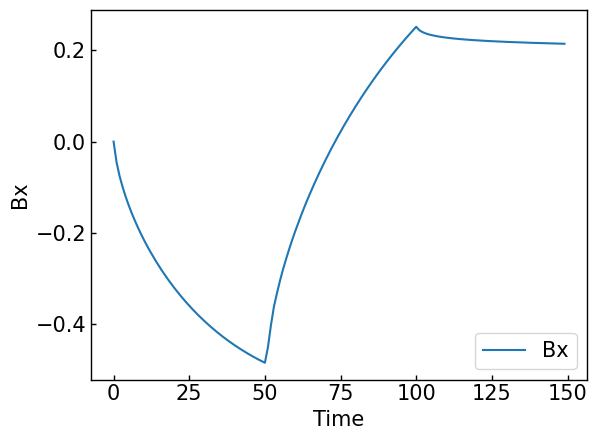

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 15  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(df_bLine1_2.iloc[:-1, -1:].values, label="Bx")
ax.set_xlabel("Time")
ax.set_ylabel("Bx")
# plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(loc="lower right")
# out_dirに保存
plt.savefig(out_dir + "beforeBx.pdf")

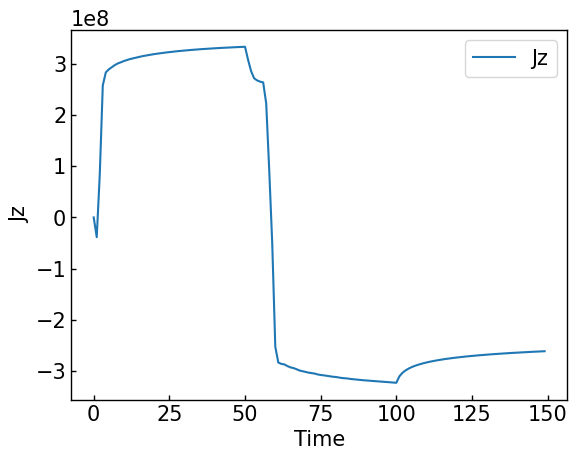

In [19]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 15  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(df_jLine1_2.iloc[:-1, -1:].values, label="Jz")
ax.set_xlabel("Time")
ax.set_ylabel("Jz")
# plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(loc="upper right")
plt.savefig("beforeJz.pdf")

In [20]:
# import matplotlib.pyplot as plt
# plt.plot(df_bLine1_3.iloc[:-1,-1:].values)
# # plt.gca().spines[['top', 'right']].set_visible(False)

In [21]:
# df_exp = sns.load_dataset('flights')
# # @title passengers

# from matplotlib import pyplot as plt
# df_exp['passengers'].plot(kind='line', figsize=(8, 4), title='passengers')
# plt.gca().spines[['top', 'right']].set_visible(False)

## データのロードと実験用の整形

In [22]:
ss = StandardScaler()

In [23]:
class HTSDataset(Dataset):
    def __init__(self, flag, seq_len, pred_len):
        # 学習期間と予測期間の設定
        self.seq_len = seq_len
        self.pred_len = pred_len

        # 訓練用、評価用、テスト用を分けるためのフラグ
        type_map = {"train": 0, "val": 1, "test": 2}
        self.set_type = type_map[flag]

        self.__read_data__()

    def __read_data__(self):
        # データの読み込み
        df_rawX = df_bLine1_3
        df_rawY = df_jLine1_3

        # 訓練用、評価用、テスト用で呼び出すデータを変える(今は変えていない全部同じ)
        # border1s = [0, 1209, 1511] #8:10:12
        # border2s = [302, 1510, 1812]
        # border1s = [0, 2416, 2718] #16:18:20
        # border2s = [2415, 2717, 3019]
        border1s = [0, 0, 0]  # 8:10:12
        border2s = [152, 152, 152]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        dataX = df_rawX.iloc[:-1, -1:].values  # 1列目のみを取り出す
        dataY = df_rawY.iloc[:-1, -1:].values  # 1列目のみを取り出す

        # data = df_raw.iloc[:-1,-1:].values
        # ss = StandardScaler()
        dataX = ss.fit_transform(dataX)
        dataY = ss.fit_transform(dataY)

        self.dataX = dataX[border1:border2]
        self.dataY = dataY[border1:border2]

    def __getitem__(self, index):
        # 学習用の系列と予測用の系列を出力
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        src = self.dataX[s_begin:s_end]
        tgt = self.dataY[s_begin:s_end]
        # tgt = self.dataY[r_begin:r_end]

        return src, tgt

    def __len__(self):
        # return len(self.dataX)
        return len(self.dataX) - self.seq_len - self.pred_len + 1

## DataLoaderの定義

In [24]:
def data_provider(flag, seq_len, pred_len, batch_size):
    # flagに合ったデータを出力
    data_set = HTSDataset(flag=flag, seq_len=seq_len, pred_len=pred_len)
    # データをバッチごとに分けて出力できるDataLoaderを使用
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=False)
    return data_loader

## エンべディングの定義

In [25]:
# 位置エンコーディングの定義
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


# モデルに入力するために次元を拡張する
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Linear(c_in, d_model)

    def forward(self, x):
        x = self.tokenConv(x)
        return x

## Transformerの定義

In [26]:
class Transformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, d_model, d_input, d_output, dim_feedforward=512, dropout=0.1, nhead=8):
        super(Transformer, self).__init__()

        # エンべディングの定義
        self.token_embedding_src = TokenEmbedding(d_input, d_model)
        self.token_embedding_tgt = TokenEmbedding(d_output, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)

        # エンコーダの定義
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, activation="gelu")
        encoder_norm = LayerNorm(d_model)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers, norm=encoder_norm)

        # デコーダの定義
        decoder_layer = TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, activation="gelu")
        decoder_norm = LayerNorm(d_model)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers, norm=decoder_norm)

        # 出力層の定義
        self.output = nn.Linear(d_model, d_output)

    def forward(self, src, tgt, mask_src, mask_tgt):
        # mask_src, mask_tgtはセルフアテンションの際に未来のデータにアテンションを向けないためのマスク

        embedding_src = self.positional_encoding(self.token_embedding_src(src))
        memory = self.transformer_encoder(embedding_src, mask_src)

        embedding_tgt = self.positional_encoding(self.token_embedding_tgt(tgt))
        outs = self.transformer_decoder(embedding_tgt, memory, mask_tgt)

        output = self.output(outs)
        return output

    def encode(self, src, mask_src):
        return self.transformer_encoder(self.positional_encoding(self.token_embedding_src(src)), mask_src)

    def decode(self, tgt, memory, mask_tgt):
        return self.transformer_decoder(self.positional_encoding(self.token_embedding_tgt(tgt)), memory, mask_tgt)

## マスクの定義

In [27]:
def create_mask(src, tgt):
    seq_len_src = src.shape[1]
    seq_len_tgt = tgt.shape[1]

    mask_tgt = generate_square_subsequent_mask(seq_len_tgt).to(device)
    mask_src = generate_square_subsequent_mask(seq_len_src).to(device)

    return mask_src, mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.full((seq_len, seq_len), float("-inf")), diagonal=1)
    return mask

## 訓練、評価の処理を定義

In [69]:
def train(model, data_provider, optimizer, criterion):
    model.train()
    total_loss = []
    count = 0
    for src, tgt in data_provider:
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        input_tgt = tgt[:, :, :]
        # input_tgt = torch.cat((src[:,-1:,:],tgt[:,:-1,:]), dim=1)

        print("src:", src.size())
        print("ターゲット:", input_tgt.size())

        mask_src, mask_tgt = create_mask(src, input_tgt)

        print("ソース", mask_src)
        print("た～げ", mask_tgt)

        output = model(src=src, tgt=input_tgt, mask_src=mask_src, mask_tgt=mask_tgt)
        print("アウトプット:", output.size())
        print("mask_src:", mask_src)
        print("mask_tgt:", mask_tgt)

        optimizer.zero_grad()

        loss = criterion(output, tgt)
        loss.backward()
        total_loss.append(loss.cpu().detach())
        optimizer.step()
        count += 1
        if count == 1209 - src_len:
            break

    return np.average(total_loss)


def evaluate(flag, model, data_provider, criterion, epoch):
    model.eval()
    total_loss = []
    for src, tgt in data_provider:
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        seq_len_src = src.shape[1]
        mask_src = (torch.zeros(seq_len_src, seq_len_src)).type(torch.bool)
        mask_src = mask_src.float().to(device)

        memory = model.encode(src, mask_src)
        outputs = tgt[:, -1:, :]
        seq_len_tgt = tgt.shape[1]

        for i in range(seq_len_tgt - 1):
            mask_tgt = (generate_square_subsequent_mask(outputs.size(1))).to(device)

            output = model.decode(outputs, memory, mask_tgt)
            output = model.output(output)

            outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)
            # outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)

        print("ターゲット", tgt.size())
        print("アウトｓ:", outputs.size())

        loss = criterion(outputs, tgt)
        total_loss.append(loss.cpu().detach())

    if flag == "test":
        true = tgt
        pred = output
        true = true.squeeze(0).cpu().detach().numpy()
        pred = pred.squeeze(0).cpu().detach().numpy()

        true = ss.inverse_transform(true)
        pred = ss.inverse_transform(pred)
        # true = torch.cat((src, tgt), dim=1)
        # pred = torch.cat((src, output), dim=1)

        fig = plt.figure()
        # ax = fig.add_subplot()
        # ax.plot(true.squeeze(), label="true")
        # ax.plot(pred.squeeze(), label="pred")
        # ax.set_xlabel("Time")
        # ax.set_ylabel("Jz")

        plt.plot(true.squeeze(), label="true")
        plt.plot(pred.squeeze(), label="pred")

        plt.xlabel("Time")
        plt.ylabel("Jz")

        plt.legend()
        plt.savefig("test2.pdf")
        # グラフを保存
        plt.title(f"epoch {epoch}")
        plt.savefig(f"epoch_{epoch}.png")
        plt.clf()

    return np.average(total_loss)

## パラメータなどの定義

In [81]:
d_input = 1
d_output = 1
d_model = 512
nhead = 8
dim_feedforward = 2048
num_encoder_layers = 4
num_decoder_layers = 4
dropout = 0.01
src_len = 151  # 36
tgt_len = 1  # 12
batch_size = 1
epochs = 100
best_loss = float("Inf")
best_model = None

model = Transformer(num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, d_model=d_model, d_input=d_input, d_output=d_output, dim_feedforward=dim_feedforward, dropout=dropout, nhead=nhead)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.RAdam(model.parameters(), lr=0.0001)

## 訓練と評価用データにおける評価

src: torch.Size([1, 151, 1])
ターゲット: torch.Size([1, 151, 1])
ソース tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
た～げ tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
アウトプット: torch.Size([1, 151, 1])
mask_src: tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
mask_tgt: tensor([[0., -inf, -inf,  ..

/var/folders/fd/wnkbrjl93y7dx79_73lc0rd00000gp/T/ipykernel_2812/1101062221.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


アウトプット: torch.Size([1, 151, 1])
mask_src: tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
mask_tgt: tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
ターゲット torch.Size([1, 151, 1])
アウトｓ: torch.Size([1, 151, 1])
[22/100] train loss: 0.342952, valid loss: 0.511743
ターゲット torch.Size([1, 151, 1])
アウトｓ: torch.Size([1, 151, 1])
src: torch.Size([1, 151, 1])
ターゲット: torch.Size([1, 151, 1])
ソース tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

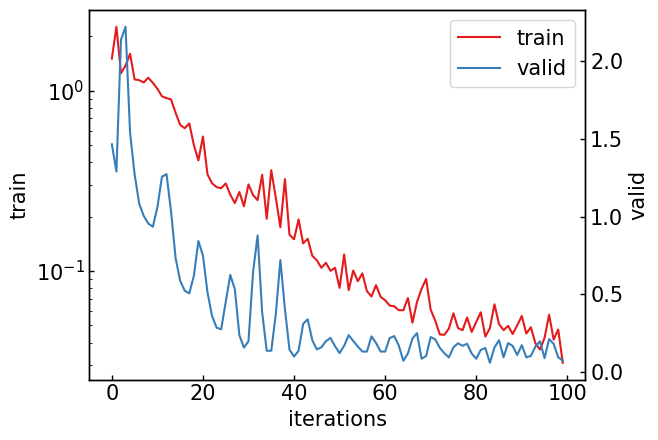

In [82]:
valid_losses = []
train_losses = []
for epoch in range(1, epochs + 1):
    loss_train = train(model=model, data_provider=data_provider("train", src_len, tgt_len, batch_size), optimizer=optimizer, criterion=criterion)

    loss_valid = evaluate(flag="val", model=model, data_provider=data_provider("val", src_len, tgt_len, batch_size), criterion=criterion, epoch=epoch)

    if epoch % 1 == 0:
        print(
            "[{}/{}] train loss: {:.6f}, valid loss: {:.6f}".format(
                epoch,
                epochs,
                loss_train,
                loss_valid,
            )
        )

    valid_losses.append(loss_valid)
    train_losses.append(loss_train)

    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        best_epoch = epoch

    evaluate(flag="test", model=best_model, data_provider=data_provider("test", src_len, tgt_len, batch_size), criterion=criterion, epoch=epoch)

# lossCSV
df_train_loss = pd.Series(train_losses)
df_valid_loss = pd.Series(valid_losses)
df_loss = pd.concat([df_train_loss, df_valid_loss], axis=1)
df_loss.to_csv("loss.csv", index=False)

from matplotlib import cm

# plt.title("Training and Validation Loss")
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(train_losses, color=cm.Set1.colors[0], label="train")
ax2.plot(valid_losses, color=cm.Set1.colors[1], label="valid")
# ax2 = ax2.gca()
ax1.set_yscale("log")
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc="upper right")
ax1.set_xlabel("iterations")
ax1.set_ylabel("train")
ax2.set_ylabel("valid")
# ax2 = ax2.gca()
# ax2.set_yscale('log')
# plt.legend()
plt.savefig("loss.pdf")

## テスト用データにおける予測

In [83]:
evaluate(flag="test", model=best_model, data_provider=data_provider("test", src_len, tgt_len, batch_size), criterion=criterion, epoch=best_epoch)

ターゲット torch.Size([1, 151, 1])
アウトｓ: torch.Size([1, 151, 1])


np.float32(0.07373128)

<Figure size 640x480 with 0 Axes>

In [32]:
# !pip install imageio

In [35]:
import imageio

# 画像ファイルをgifに変換
images = []
for i in range(1, 1000):
    images.append(imageio.imread(f"epoch_{i}.png"))
imageio.mimsave("animation.gif", images, fps=60)


# # 作成したファイルを削除
# for i in range(epochs):
#     import os
#     os.remove(f'epoch_{i}.png')

# 作成したgif動画再生
import IPython

IPython.display.Image("animation.gif", format="png")

/var/folders/fd/wnkbrjl93y7dx79_73lc0rd00000gp/T/ipykernel_2812/3363714955.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"epoch_{i}.png"))


FileNotFoundError: No such file: '/Users/sh-shuan/develop/HTS_transformer/src/hts_transformer/epoch_2.png'